In [101]:
%matplotlib notebook
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt

In [102]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [103]:
engine = create_engine("sqlite:///hawaii.sqlite")

In [104]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [105]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [106]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [107]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [108]:
engine.execute('SELECT * FROM Station LIMIT 5').fetchall()

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6)]

In [109]:
engine.execute('SELECT * FROM Measurement LIMIT 5').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0)]

In [110]:
#design a query to retrieve the last 12 months of precipitation data
recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(recent_date)

('2017-08-23',)


In [111]:
#calc the date one year from today
one_year_ago = dt.date(2017, 8, 23) - dt.timedelta(days=365)
print(one_year_ago)

2016-08-23


In [112]:
#perform a query to retrieve the data and prcp values
prcp_data = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date > one_year_ago).\
    order_by(Measurement.date).all()

#save as dataframe and set index to date 
prcp_data_df = pd.DataFrame(prcp_data)
prcp_data_df.head()

,date,prcp
0,2016-08-24,0.08
1,2016-08-24,2.15
2,2016-08-24,2.28
3,2016-08-24,NaN
4,2016-08-24,1.22


In [113]:
prcp_data_df.set_index('date').head()

,prcp
date,
2016-08-24,0.08
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,NaN
2016-08-24,1.22


<IPython.core.display.Javascript object>


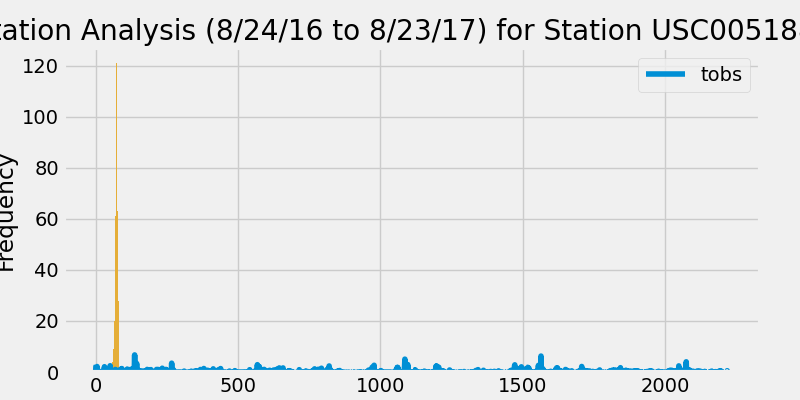

In [114]:
ax = prcp_data_df.plot(figsize=(8,4))
ax.set_title("Precipitation Analysis (8/24/16 to 8/23/17)")
ax.set_ylabel('frequency')
plt.show()

In [115]:
#Use Pandas to print the summary statistics for the precipitation data.
prcp_data_df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [116]:
# How many stations are available in this dataset?
locations = session.query(Measurement).group_by(Measurement.station).count()
print("There are {} stations available.".format(locations))

There are 9 stations available.


In [117]:
# What are the most active stations?
active = session.query(Measurement.station, func.count(Measurement.station).label('count')).\
            group_by(Measurement.station).\
            order_by('count').all()
active

[('USC00518838', 511),
 ('USC00517948', 1372),
 ('USC00511918', 1979),
 ('USC00514830', 2202),
 ('USC00516128', 2612),
 ('USC00519523', 2669),
 ('USC00513117', 2709),
 ('USC00519397', 2724),
 ('USC00519281', 2772)]

In [118]:
##most active station id
most_active = session.query(Measurement.station, 
                                    func.count(Measurement.station).\
                                    label('count')).\
                                    group_by(Measurement.station).\
                                    order_by('count').limit(1)[0][0]
most_active

'USC00518838'

In [119]:
#lowest, highest, and average temperature
temp = [func.min(Measurement.tobs),
       func.max(Measurement.tobs),
       func.avg(Measurement.tobs)]
session.query(*temp).filter(Measurement.station==most_active).all()


[(58.0, 83.0, 72.72407045009784)]

In [120]:
temp_obs = session.query(Measurement.tobs).filter(Measurement.station==most_active).filter(Measurement.date <= one_year_ago).all()


temp_obs
temp_obs_df = pd.DataFrame(temp_obs)
temp_obs_df.head()

,tobs
0,72.0
1,73.0
2,67.0
3,76.0
4,73.0


In [122]:
plt.hist(temp_obs_df['tobs'], bins=12)
plt.xlabel("Recorded Temperature")
plt.ylabel("Frequency")
plt.title("Station Analysis (8/24/16 to 8/23/17) for Station " + most_active)
plt.legend(["tobs"])
plt.show()

In [123]:
session.close()